### IMPORT DEPENDENCIES AND LIBRARY METHODS AND CLASSES

In [1]:
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from models.MLP import MLP0, MLP1, MLP2
from util import seed_everything, \
    train, test, preprocess_dataset, MultiTransforms, \
    TransformPCA, SatelliteDataset
import argparse
from torch.utils.data import DataLoader

In [2]:
seed_everything(42)
IN_DIMS = 36
OUT_DIMS = 6  # label 6 has zero items so 6 classes only
DEVICE = "cuda:0"
ROOT_DIR = "dataset"

### DATASET CREATION, PREPROCESSING AND DATALOADERS 

In [3]:
train_dataset = SatelliteDataset("./dataset", train=True)
test_dataset = SatelliteDataset("./dataset", train=False)

# mean center and normalize
transform, target_transform = preprocess_dataset(train_dataset)

train_dataset.transform = transform
train_dataset.target_transform = target_transform

test_dataset.transform = transform
test_dataset.target_transform = target_transform

In [4]:
train_loader = DataLoader(train_dataset, batch_size=1,
                          shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256,
                         shuffle=False, num_workers=4)


In [5]:
def fit(
    model: nn.Module,
    train_loader,
    test_loader,
    args,
):
    train_accuracies = []
    test_accuracies = []

    best_train_acc = 0
    best_test_acc = 0

    progress_bar = tqdm(range(args.max_epochs),
                        desc="Epochs", disable=not args.verbose)

    for i in progress_bar:
        _, train_acc = train(model, train_loader,
                             lr=args.lr, device=args.device)
        train_accuracies.append(train_acc)
        best_train_acc = max(best_train_acc, train_acc)

        test_acc = 0
        progress_dict = {"Train Acc": train_acc}

        if i % args.test_freq == 0:
            results = test(model, test_loader,
                           device=args.device, metrics=["Accuracy"])
            test_acc = results["Accuracy"]

            test_accuracies.append(test_acc)
            progress_dict["Test Accuracy"] = test_acc
            best_test_acc = max(best_test_acc, test_acc)

        if i % args.log_freq == 0 and args.verbose:
            progress_bar.set_postfix(progress_dict)

    if args.plot is True:
        plt.plot(train_accuracies, label="Train")
        plt.plot(test_accuracies, label="test")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.show()

    return best_train_acc, best_test_acc


## Results for model architecture:
1. 0 hidden layers
2. sigmoid activation function
3. input_dim = 36, output_dim = 6

In [ ]:
models = {
    "MLP0":   (MLP0, [IN_DIMS, OUT_DIMS]),
    "MLP1_0": (MLP1, [IN_DIMS, OUT_DIMS, 2]),
    "MLP1_1": (MLP1, [IN_DIMS, OUT_DIMS, 6]),
    "MLP2_0": (MLP2, [IN_DIMS, OUT_DIMS, 2, 3]),
    "MLP2_1": (MLP2, [IN_DIMS, OUT_DIMS, 3, 2]),
}

results = dict()
lrs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

for name, (cls, args) in models.items():
    results[name] = []
    for lr in lrs:
        model = cls(*args).to(DEVICE)
        fit_args = argparse.Namespace(max_epochs=5, lr=lr, device=DEVICE,
                                      verbose=False, log_freq=1, test_freq=1, plot=False)
        train_acc,  test_acc = fit(model, train_loader, test_loader, fit_args)
        results[name].append((train_acc, test_acc))
        print(f"{name} with lr {lr} test accuracy: {test_acc}")

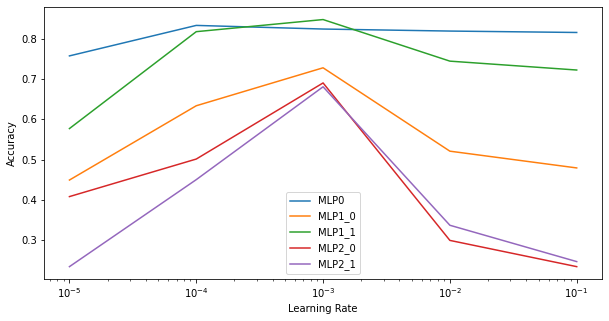

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name, accs in results.items():
    ax.plot(lrs, [a[1] for a in accs], label=name)
    ax.set_xscale("log")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()

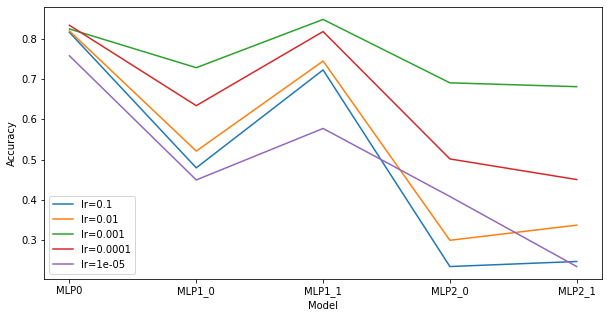

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

names = list(results.keys())
for i, lr in enumerate(lrs):
    ax.plot(names, [accs[i][1] for accs in results.values()], label=f"lr={lr}")
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()

In [6]:
train_dataset = SatelliteDataset("./dataset", train=True)
test_dataset = SatelliteDataset("./dataset", train=False)

# mean center and normalize
transform, target_transform = preprocess_dataset(train_dataset)

train_dataset.data -= transform.mean
train_dataset.data /= transform.std_dev

train_dataset.targets = np.array(
    [target_transform(x) for x in train_dataset.targets], dtype=np.int32)

test_dataset.data -= transform.mean
test_dataset.data /= transform.std_dev

test_dataset.targets = np.array(
    [target_transform(x) for x in test_dataset.targets], dtype=np.int32)

pca = PCA(n_components=2)
pca.fit(train_dataset.data)

train_dataset.data = pca.transform(train_dataset.data)
test_dataset.data = pca.transform(test_dataset.data)

train_loader = DataLoader(train_dataset, batch_size=1,
                          shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256,
                         shuffle=False, num_workers=4)


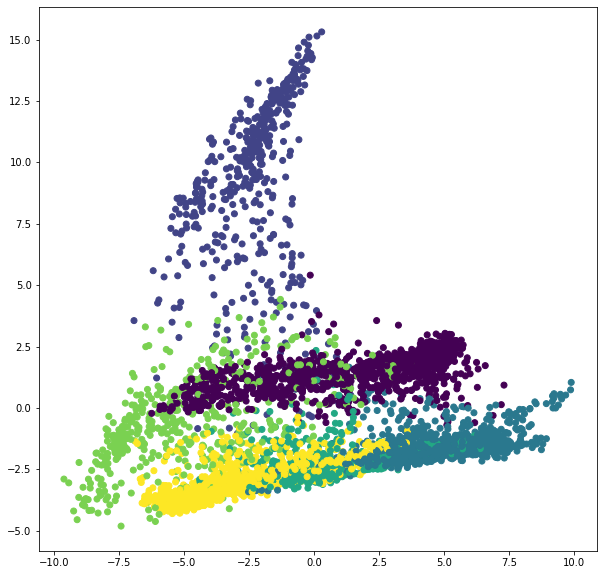

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(train_dataset.data[:, 0],
           train_dataset.data[:, 1], c=train_dataset.targets)
plt.show()

In [ ]:
models = {
    "MLP0":   (MLP0, [2, OUT_DIMS]),
    "MLP1_0": (MLP1, [2, OUT_DIMS, 2]),
    "MLP1_1": (MLP1, [2, OUT_DIMS, 6]),
    "MLP2_0": (MLP2, [2, OUT_DIMS, 2, 3]),
    "MLP2_1": (MLP2, [2, OUT_DIMS, 3, 2]),
}

results = dict()
for name, (cls, args) in models.items():
    model = cls(*args).to(DEVICE)
    fit_args = argparse.Namespace(max_epochs=5, lr=1e-3, device=DEVICE,
                                  verbose=False, log_freq=1, test_freq=1, plot=False)
    train_acc,  test_acc = fit(model, train_loader, test_loader, fit_args)
    results[name] = (train_acc, test_acc)
    print(f"{name} with test accuracy after PCA: {test_acc}")


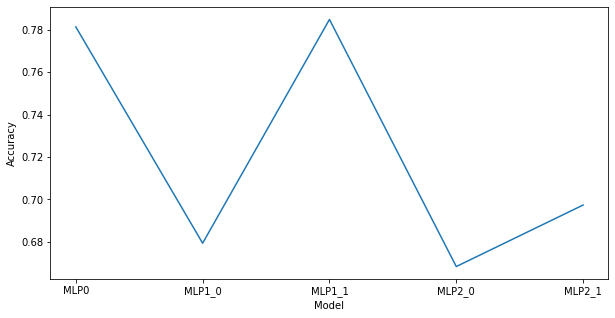

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

names = list(results.keys())
ax.plot(names, [accs[1] for accs in results.values()])
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
plt.show()